# LTV модель (12 месяцев)

**Цель:** построить прогноз LTV на 12 месяцев с оценкой качества на временном holdout.

**Подходы:**
- Baseline (исторический факт за последние 12м)
- ElasticNet регрессия (линейная модель)
- LightGBM (градиентный бустинг)
- BG/NBD + Gamma-Gamma (вероятностная модель)

**Метрики:** MAE, RMSE, R2, MAPE

## 1. Настройка окружения

### 1.1 Импорты

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import timedelta

from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 50)
sns.set(style='whitegrid')

### 1.2 Конфигурация

In [2]:
DATA_DIR = Path('../data')
REVENUE_PATH = DATA_DIR / 'revenue.csv'

RANDOM_STATE = 42
TEST_SIZE = 0.2
HOLDOUT_MONTHS = 12

print(f"Путь к данным: {REVENUE_PATH.resolve()}")
print(f"Файл существует: {REVENUE_PATH.exists()}")

Путь к данным: /home/serge/Dev/praktikum_v2/mts_link/data/revenue.csv
Файл существует: True


## 2. Загрузка и подготовка данных

### 2.1 Функция загрузки

In [3]:
def load_revenue(path: Path) -> pd.DataFrame:
    """Загрузка и первичная обработка данных о продажах."""
    df = pd.read_csv(path, dtype=str)
    df['product_sum'] = pd.to_numeric(df['product_sum'], errors='coerce')
    df['product_duration'] = pd.to_numeric(df['product_duration'], errors='coerce')
    df['sale_date'] = pd.to_datetime(df['sale_date'], errors='coerce')
    df = df.dropna(subset=['sale_date'])
    return df

### 2.2 Загрузка данных

In [4]:
revenue_df = load_revenue(REVENUE_PATH)

print(f"Загружено строк: {len(revenue_df):,}")
print(f"Диапазон дат: {revenue_df['sale_date'].min().date()} -> {revenue_df['sale_date'].max().date()}")
print(f"Уникальных компаний: {revenue_df['company_id'].nunique():,}")
revenue_df.head(3)

Загружено строк: 16,820
Диапазон дат: 2014-01-22 -> 2023-10-13
Уникальных компаний: 2,120


,Unnamed: 0,row_id,company_id,sale_id,sale_date,product_name,product_sum,sale_type,product_duration
0,0,row_8ae3f0a90135,comp_94b3dbfa3cdb,sal_117719067179,2021-02-09,Расширения,10000,Новая,1
1,1,row_e056ebe0bd07,comp_94b3dbfa3cdb,sal_8f5df72ac2f7,2023-03-17,Расширения,10000,Продление,1
2,2,row_04471fe231b0,comp_94b3dbfa3cdb,sal_117719067179,2021-02-09,Тарифы Webinar СМБ,11000,Новая,1


### 2.3 Разделение на train / holdout

In [5]:
snapshot = revenue_df['sale_date'].max()
cutoff = snapshot - pd.DateOffset(months=HOLDOUT_MONTHS)

train_tx = revenue_df[revenue_df['sale_date'] <= cutoff]
holdout_tx = revenue_df[(revenue_df['sale_date'] > cutoff) & (revenue_df['sale_date'] <= snapshot)]

print(f"Train период: до {cutoff.date()}, строк: {len(train_tx):,}")
print(f"Holdout период: {cutoff.date()} - {snapshot.date()}, строк: {len(holdout_tx):,}")

Train период: до 2022-10-13, строк: 14,151
Holdout период: 2022-10-13 - 2023-10-13, строк: 2,669


## 3. Feature Engineering

Строим признаки на основе исторических данных (до cutoff):
- **Базовые RFM**: recency, frequency, monetary, mean_cheque, customer_age
- **Временные (12м)**: freq_12m, monetary_12m, orders_12m, growth_rate_12m
- **Продуктовые**: n_unique_products, renewal_share_line, has_collab
- **Чековые**: median_check, check_cv, last_check_ratio

### 3.1 Базовые RFM-признаки

In [6]:
def build_features(tx: pd.DataFrame, ref_date: pd.Timestamp) -> pd.DataFrame:
    """Агрегация базовых RFM-признаков по клиентам на дату среза."""
    agg = (
        tx.groupby('company_id')
        .agg(
            first_purchase=('sale_date', 'min'),
            last_purchase=('sale_date', 'max'),
            frequency=('sale_id', 'nunique'),
            monetary=('product_sum', 'sum'),
            mean_cheque=('product_sum', 'mean')
        )
        .reset_index()
    )
    agg['recency'] = (ref_date - agg['last_purchase']).dt.days
    agg['T'] = (ref_date - agg['first_purchase']).dt.days
    agg['customer_age_days'] = agg['T']
    return agg

### 3.2 Расширенные признаки

In [7]:
def build_enhanced_features(tx: pd.DataFrame, ref_date: pd.Timestamp) -> pd.DataFrame:
    """Расширенный набор признаков: RFM + временные + продуктовые + чековые."""
    
    base = build_features(tx, ref_date)
    
    window_12m_start = ref_date - pd.DateOffset(years=1)
    window_12m = tx[tx['sale_date'] > window_12m_start]
    
    temporal_12m = (
        window_12m.groupby('company_id')
        .agg(
            freq_12m=('sale_id', 'nunique'),
            monetary_12m=('product_sum', 'sum'),
            orders_12m=('row_id', 'count')
        )
        .reset_index()
    )
    
    window_prev12m_start = ref_date - pd.DateOffset(years=2)
    window_prev12m = tx[(tx['sale_date'] > window_prev12m_start) & (tx['sale_date'] <= window_12m_start)]
    prev_monetary = window_prev12m.groupby('company_id')['product_sum'].sum().rename('monetary_prev12m')
    
    temporal_12m = temporal_12m.merge(prev_monetary, on='company_id', how='left')
    temporal_12m['monetary_prev12m'] = temporal_12m['monetary_prev12m'].fillna(0)
    temporal_12m['growth_rate_12m'] = np.where(
        temporal_12m['monetary_prev12m'] > 0,
        temporal_12m['monetary_12m'] / temporal_12m['monetary_prev12m'],
        0
    )
    
    product_features = (
        tx.groupby('company_id')
        .agg(
            n_unique_products=('product_name', 'nunique'),
            renewal_lines=('sale_type', lambda s: (s == 'Продление').sum()),
            total_lines=('sale_type', 'count')
        )
        .reset_index()
    )
    product_features['renewal_share_line'] = (
        product_features['renewal_lines'] / product_features['total_lines'].replace(0, np.nan)
    ).fillna(0)
    
    collab_keywords = ['Доски', 'Чаты', 'МТС Линк']
    tx_temp = tx.copy()
    tx_temp['is_collab'] = tx_temp['product_name'].apply(
        lambda x: any(kw in str(x) for kw in collab_keywords) if pd.notna(x) else False
    )
    collab_flags = tx_temp.groupby('company_id')['is_collab'].any().astype(int).rename('has_collab').reset_index()
    
    check_features = (
        tx.groupby('company_id')['product_sum']
        .agg(['mean', 'median', 'std'])
        .reset_index()
        .rename(columns={'mean': 'mean_check', 'median': 'median_check', 'std': 'check_std'})
    )
    check_features['check_cv'] = (
        check_features['check_std'] / (check_features['mean_check'] + 1e-6)
    ).fillna(0)
    
    last_checks = (
        tx.sort_values('sale_date')
        .groupby('company_id')
        .tail(1)[['company_id', 'product_sum']]
        .rename(columns={'product_sum': 'last_check'})
    )
    check_features = check_features.merge(last_checks, on='company_id', how='left')
    check_features['last_check_ratio'] = (
        check_features['last_check'] / (check_features['mean_check'] + 1e-6)
    ).fillna(1)
    
    enhanced = (
        base
        .merge(temporal_12m, on='company_id', how='left')
        .merge(product_features[['company_id', 'n_unique_products', 'renewal_share_line']], on='company_id', how='left')
        .merge(collab_flags, on='company_id', how='left')
        .merge(check_features[['company_id', 'median_check', 'check_cv', 'last_check_ratio']], on='company_id', how='left')
    )
    
    enhanced = enhanced.fillna({
        'freq_12m': 0, 'monetary_12m': 0, 'orders_12m': 0, 'growth_rate_12m': 0,
        'n_unique_products': 0, 'renewal_share_line': 0, 'has_collab': 0,
        'median_check': 0, 'check_cv': 0, 'last_check_ratio': 1
    })
    
    return enhanced

### 3.3 Построение признаков

In [8]:
features_enhanced = build_enhanced_features(train_tx, cutoff)

print(f"Признаков: {features_enhanced.shape[1]}, Клиентов: {features_enhanced.shape[0]:,}")
features_enhanced.head(3)

Признаков: 20, Клиентов: 1,980


,company_id,first_purchase,last_purchase,frequency,monetary,mean_cheque,recency,T,customer_age_days,freq_12m,monetary_12m,orders_12m,monetary_prev12m,growth_rate_12m,n_unique_products,renewal_share_line,has_collab,median_check,check_cv,last_check_ratio
0,comp_0004b685d8d6,2019-05-03,2019-05-03,1,17000,17000.000000,1259,1259,1259,0.0,0.0,0.0,NaN,0.0,1,0.000000,0,17000.0,0.000000,1.000000
1,comp_001eac7794df,2020-09-23,2022-09-25,19,190000,10000.000000,18,750,750,8.0,80000.0,8.0,100000.0,0.8,1,0.578947,0,10000.0,0.000000,1.000000
2,comp_002f5166d79b,2020-11-28,2020-11-28,1,31000,10333.333333,684,684,684,0.0,0.0,0.0,NaN,0.0,2,0.000000,0,10000.0,0.055873,1.064516


### 3.4 Целевая переменная

In [9]:
target = (
    holdout_tx.groupby('company_id')['product_sum']
    .sum()
    .rename('ltv_12m_actual')
    .reset_index()
)

X = features_enhanced.merge(target, on='company_id', how='left')
X['ltv_12m_actual'] = X['ltv_12m_actual'].fillna(0)

print(f"Итоговый датасет: {X.shape}")
print(f"Клиентов с LTV > 0: {(X['ltv_12m_actual'] > 0).sum():,} ({(X['ltv_12m_actual'] > 0).mean()*100:.1f}%)")

Итоговый датасет: (1980, 21)
Клиентов с LTV > 0: 721 (36.4%)


### 3.5 Train / Validation split

In [10]:
train_ids, val_ids = train_test_split(
    X['company_id'], test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)
train_df = X[X['company_id'].isin(train_ids)].copy()
val_df = X[X['company_id'].isin(val_ids)].copy()

feature_cols_base = [
    'recency', 'frequency', 'monetary', 'mean_cheque', 'customer_age_days', 'monetary_12m'
]

feature_cols_enhanced = [
    'recency', 'frequency', 'monetary', 'mean_cheque', 'customer_age_days',
    'freq_12m', 'monetary_12m', 'orders_12m', 'growth_rate_12m',
    'n_unique_products', 'renewal_share_line', 'has_collab',
    'median_check', 'check_cv', 'last_check_ratio'
]

feature_cols = feature_cols_enhanced

X_train = train_df[feature_cols]
y_train = train_df['ltv_12m_actual']
X_val = val_df[feature_cols]
y_val = val_df['ltv_12m_actual']

print(f"Train: {len(train_df):,}, Val: {len(val_df):,}")
print(f"Признаков: {len(feature_cols)}")

Train: 1,584, Val: 396
Признаков: 15


## 4. Метрики качества

In [11]:
def rmse(y_true, y_pred):
    """Root Mean Squared Error."""
    return mean_squared_error(y_true, y_pred) ** 0.5


def mape(y_true, y_pred, eps=1e-6):
    """Mean Absolute Percentage Error (для ненулевых значений)."""
    mask = np.abs(y_true) > eps
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


def evaluate_preds(name, y_true, y_pred, extended=False):
    """Оценка качества регрессии."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mae_val = mean_absolute_error(y_true, y_pred)
    rmse_val = rmse(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape_val = mape(y_true, y_pred)
    
    print(f"\n{name}")
    print(f"  MAE:  {mae_val:,.2f}")
    print(f"  RMSE: {rmse_val:,.2f}")
    print(f"  R2:   {r2:.4f}")
    if not np.isnan(mape_val):
        print(f"  MAPE: {mape_val:.1f}%")
    
    if extended:
        median_ae = np.median(np.abs(y_true - y_pred))
        print(f"  MedAE: {median_ae:,.2f}")
    
    return mae_val, rmse_val, r2, mape_val

## 5. Моделирование

### 5.1 Baseline (monetary_12m)

Простое правило: LTV за следующие 12м = LTV за предыдущие 12м.

In [12]:
baseline_mae, baseline_rmse, baseline_r2, baseline_mape = evaluate_preds(
    'Baseline: monetary_12m', y_val, X_val['monetary_12m']
)


Baseline: monetary_12m
  MAE:  17,505.05
  RMSE: 37,531.47
  R2:   0.0696
  MAPE: 67.3%


### 5.2 ElasticNet (линейная регрессия)

In [13]:
alpha_grid = np.logspace(-3, 2, 20)

model_base = ElasticNetCV(alphas=alpha_grid, l1_ratio=[0.1, 0.5, 0.9], cv=5, random_state=RANDOM_STATE)
model_base.fit(train_df[feature_cols_base], y_train)
pred_base = model_base.predict(val_df[feature_cols_base])
base_mae, base_rmse, base_r2, base_mape = evaluate_preds('ElasticNet (6 базовых фич)', y_val, pred_base)

model_enhanced = ElasticNetCV(alphas=alpha_grid, l1_ratio=[0.1, 0.5, 0.9], cv=5, random_state=RANDOM_STATE)
model_enhanced.fit(X_train, y_train)
pred_enhanced = model_enhanced.predict(X_val)
enh_mae, enh_rmse, enh_r2, enh_mape = evaluate_preds('ElasticNet (15 расширенных фич)', y_val, pred_enhanced)


ElasticNet (6 базовых фич)
  MAE:  23,208.96
  RMSE: 44,010.25
  R2:   -0.2793
  MAPE: 87.4%

ElasticNet (15 расширенных фич)
  MAE:  22,955.46
  RMSE: 43,688.89
  R2:   -0.2607
  MAPE: 86.0%


### 5.3 LightGBM (градиентный бустинг)

In [14]:
lgb_params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': RANDOM_STATE
}

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

model_lgb = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'val'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=100)
    ]
)

pred_lgb = model_lgb.predict(X_val, num_iteration=model_lgb.best_iteration)
lgb_mae, lgb_rmse, lgb_r2, lgb_mape = evaluate_preds('LightGBM (15 фич)', y_val, pred_lgb, extended=True)

print(f"\nМодель: {model_lgb.best_iteration} итераций")

[100]	train's l1: 13234.3	val's l1: 17369.4

LightGBM (15 фич)
  MAE:  17,096.04
  RMSE: 34,663.51
  R2:   0.2064
  MAPE: 65.0%
  MedAE: 6,088.37

Модель: 81 итераций


### 5.4 BG/NBD + Gamma-Gamma. Вероятностная модель.

In [15]:
summary = summary_data_from_transaction_data(
    train_tx,
    customer_id_col='company_id',
    datetime_col='sale_date',
    monetary_value_col='product_sum',
    observation_period_end=cutoff,
    freq='D'
)

bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

summary_monetary = summary[summary['monetary_value'] > 0]
ggf = GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(summary_monetary['frequency'], summary_monetary['monetary_value'])

pred_purchases = bgf.predict(365, summary['frequency'], summary['recency'], summary['T'])
pred_monetary = ggf.conditional_expected_average_profit(summary_monetary['frequency'], summary_monetary['monetary_value'])

pred_df = summary[['frequency', 'recency', 'T']].copy()
pred_df['pred_purchases_12m'] = pred_purchases
pred_df['pred_avg_monetary'] = pred_df.index.map(pred_monetary)

fallback_cheque = summary_monetary['monetary_value'].mean()
pred_df['pred_avg_monetary'] = pred_df['pred_avg_monetary'].fillna(fallback_cheque)
pred_df['ltv_pred_bg_gammagamma'] = pred_df['pred_purchases_12m'] * pred_df['pred_avg_monetary']

val_bg = val_df.merge(
    pred_df[['pred_purchases_12m', 'pred_avg_monetary', 'ltv_pred_bg_gammagamma']], 
    left_on='company_id', right_index=True, how='left'
)
val_bg['ltv_pred_bg_gammagamma'] = val_bg['ltv_pred_bg_gammagamma'].fillna(0)

bg_mae, bg_rmse, bg_r2, bg_mape = evaluate_preds(
    'BG/NBD + Gamma-Gamma', val_bg['ltv_12m_actual'], val_bg['ltv_pred_bg_gammagamma']
)


BG/NBD + Gamma-Gamma
  MAE:  18,643.47
  RMSE: 32,082.02
  R2:   0.3202
  MAPE: 59.3%


## 6. Сравнение моделей

### 6.1 Сводная таблица результатов

In [16]:
results_all = pd.DataFrame({
    'Модель': [
        'Baseline (monetary_12m)', 
        'ElasticNet (6 фич)', 
        'ElasticNet (15 фич)', 
        'LightGBM (15 фич)',
        'BG/NBD + Gamma-Gamma'
    ],
    'MAE': [baseline_mae, base_mae, enh_mae, lgb_mae, bg_mae],
    'RMSE': [baseline_rmse, base_rmse, enh_rmse, lgb_rmse, bg_rmse],
    'R2': [baseline_r2, base_r2, enh_r2, lgb_r2, bg_r2]
})

results_all['MAE улучш.%'] = (
    (results_all['MAE'].iloc[0] - results_all['MAE']) / results_all['MAE'].iloc[0] * 100
).round(1)

print("=" * 85)
print("СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ")
print("=" * 85)
print(results_all.to_string(index=False, float_format=lambda x: f'{x:,.2f}' if abs(x) > 1 else f'{x:.4f}'))

best_idx = results_all['MAE'].idxmin()
best_model = results_all.loc[best_idx, 'Модель']
best_mae = results_all.loc[best_idx, 'MAE']
best_r2 = results_all.loc[best_idx, 'R2']
best_improvement = results_all.loc[best_idx, 'MAE улучш.%']

print(f"\n{'='*85}")
print(f"ЛУЧШАЯ МОДЕЛЬ: {best_model}")
print(f"  MAE: {best_mae:,.0f} (улучшение {best_improvement:+.1f}% vs baseline)")
print(f"  R2:  {best_r2:.4f}")
print(f"{'='*85}")

СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ
                 Модель       MAE      RMSE      R2  MAE улучш.%
Baseline (monetary_12m) 17,505.05 37,531.47  0.0696       0.0000
     ElasticNet (6 фич) 23,208.96 44,010.25 -0.2793       -32.60
    ElasticNet (15 фич) 22,955.46 43,688.89 -0.2607       -31.10
      LightGBM (15 фич) 17,096.04 34,663.51  0.2064         2.30
   BG/NBD + Gamma-Gamma 18,643.47 32,082.02  0.3202        -6.50

ЛУЧШАЯ МОДЕЛЬ: LightGBM (15 фич)
  MAE: 17,096 (улучшение +2.3% vs baseline)
  R2:  0.2064


### 6.2 Важность признаков

In [17]:
importance_lgb = pd.DataFrame({
    'feature': feature_cols_enhanced,
    'importance': model_lgb.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

coefs = pd.DataFrame({
    'feature': feature_cols_enhanced,
    'coef': model_enhanced.coef_,
    'abs_coef': np.abs(model_enhanced.coef_)
}).sort_values('abs_coef', ascending=False)

print("Топ-10 признаков (LightGBM gain):")
print(importance_lgb.head(10).to_string(index=False))

Топ-10 признаков (LightGBM gain):
           feature   importance
      monetary_12m 1.461108e+13
          check_cv 1.017409e+13
          monetary 8.768627e+12
       mean_cheque 3.515269e+12
        orders_12m 3.384742e+12
   growth_rate_12m 1.816739e+12
           recency 1.491347e+12
  last_check_ratio 9.985739e+11
renewal_share_line 8.848229e+11
 customer_age_days 4.844126e+11


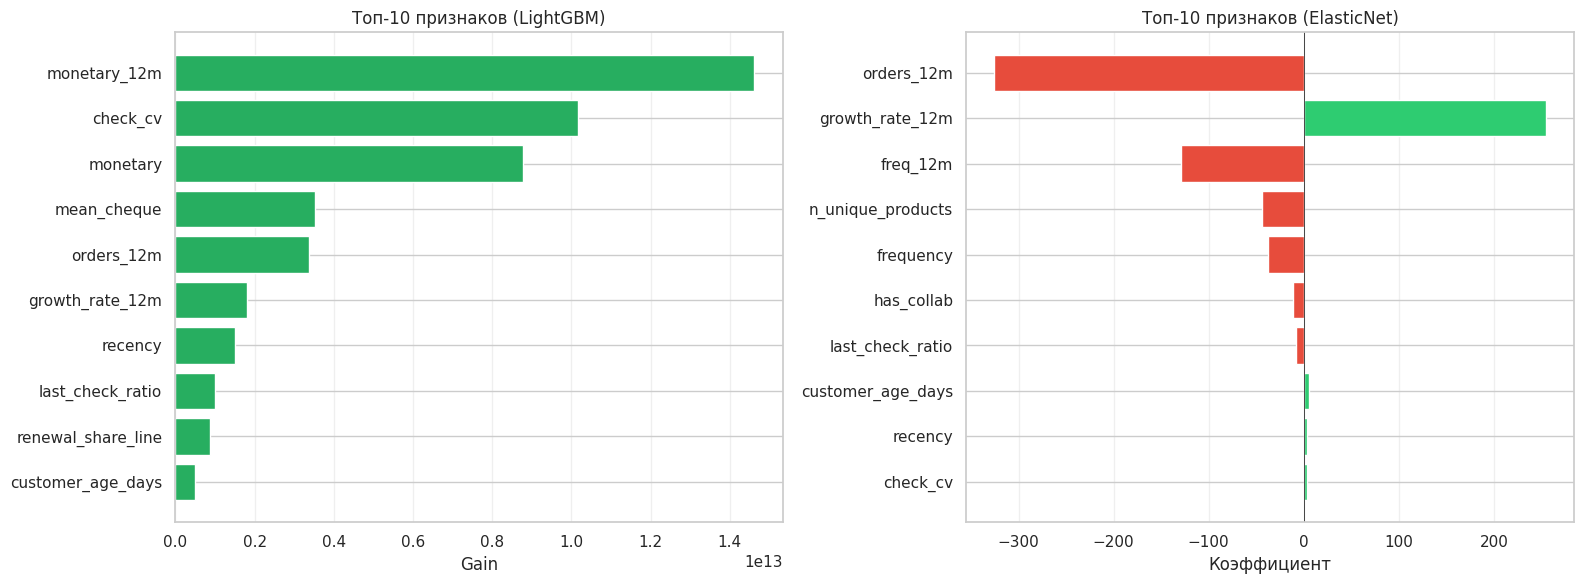

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top10_lgb = importance_lgb.head(10)
axes[0].barh(top10_lgb['feature'], top10_lgb['importance'], color='#27ae60')
axes[0].set_xlabel('Gain')
axes[0].set_title('Топ-10 признаков (LightGBM)')
axes[0].invert_yaxis()
axes[0].grid(alpha=0.3, axis='x')

top10_en = coefs.head(10)
colors_en = ['#2ecc71' if c > 0 else '#e74c3c' for c in top10_en['coef']]
axes[1].barh(top10_en['feature'], top10_en['coef'], color=colors_en)
axes[1].set_xlabel('Коэффициент')
axes[1].set_title('Топ-10 признаков (ElasticNet)')
axes[1].invert_yaxis()
axes[1].axvline(x=0, color='black', linewidth=0.5)
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### 6.3 Визуализация прогнозов

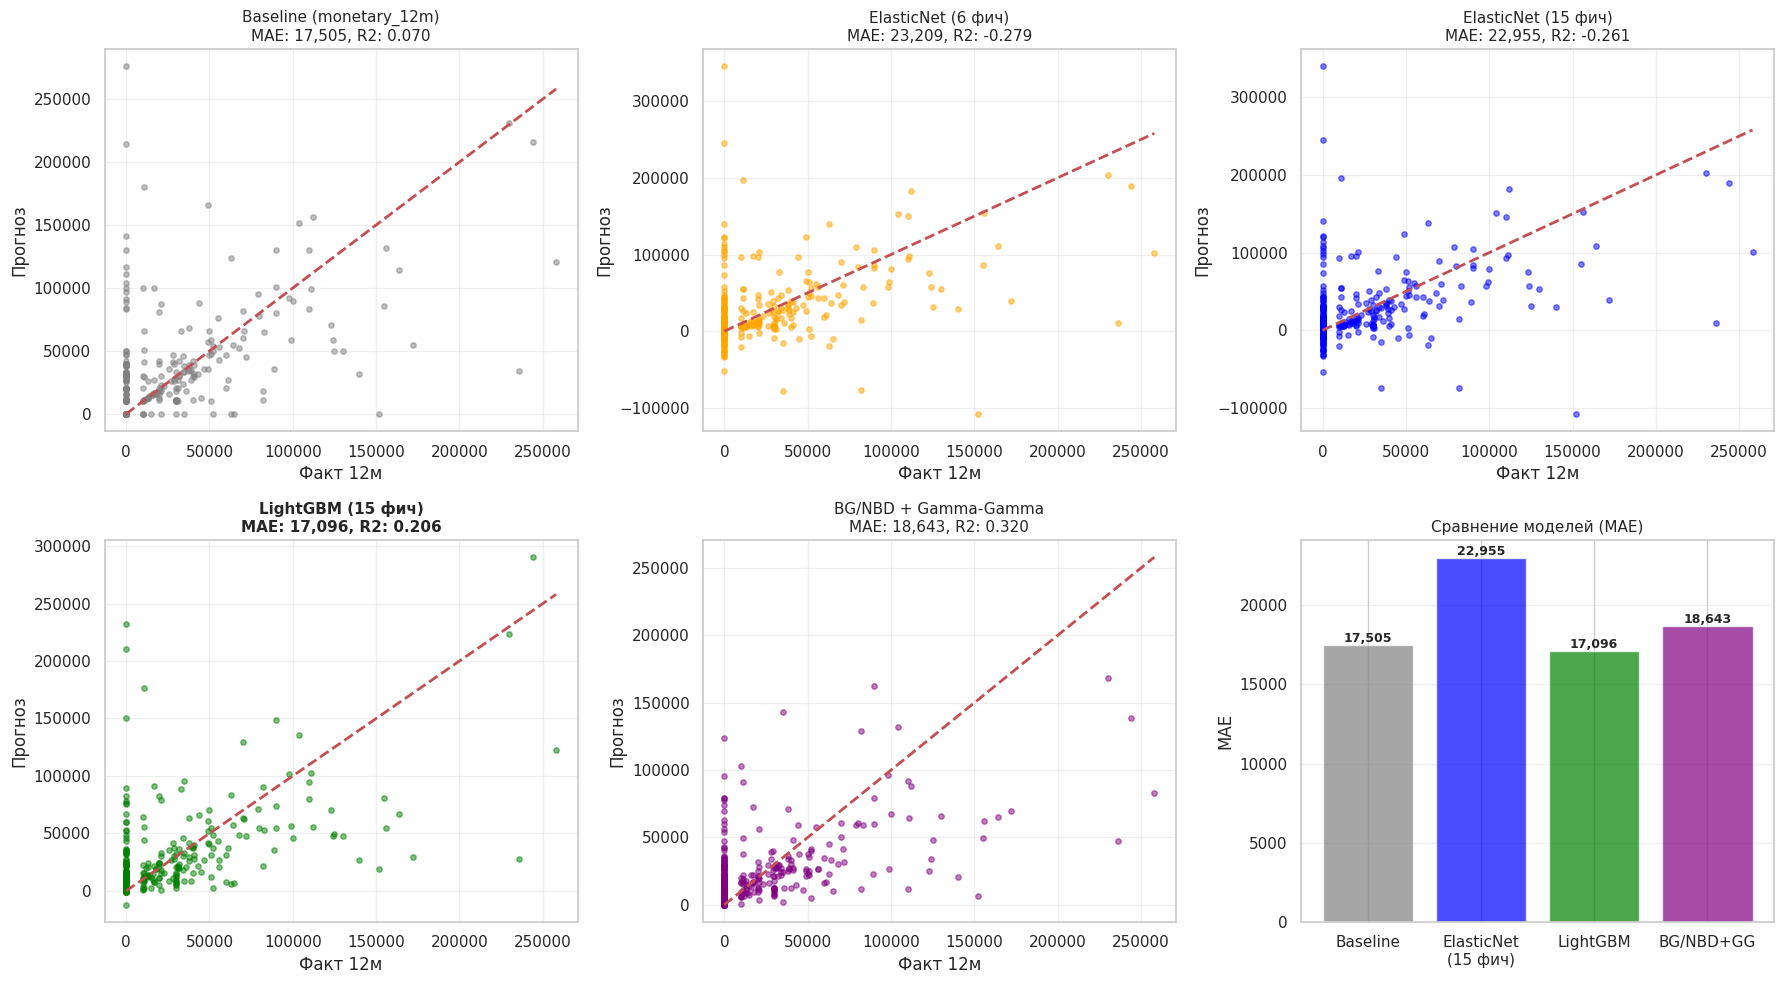

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
max_val = val_df['ltv_12m_actual'].max()

axes[0,0].scatter(val_df['ltv_12m_actual'], X_val['monetary_12m'], alpha=0.5, s=15, color='gray')
axes[0,0].plot([0, max_val], [0, max_val], 'r--', linewidth=2)
axes[0,0].set_title(f'Baseline (monetary_12m)\nMAE: {baseline_mae:,.0f}, R2: {baseline_r2:.3f}', fontsize=11)
axes[0,0].set_xlabel('Факт 12м')
axes[0,0].set_ylabel('Прогноз')
axes[0,0].grid(alpha=0.3)

axes[0,1].scatter(val_df['ltv_12m_actual'], pred_base, alpha=0.5, s=15, color='orange')
axes[0,1].plot([0, max_val], [0, max_val], 'r--', linewidth=2)
axes[0,1].set_title(f'ElasticNet (6 фич)\nMAE: {base_mae:,.0f}, R2: {base_r2:.3f}', fontsize=11)
axes[0,1].set_xlabel('Факт 12м')
axes[0,1].set_ylabel('Прогноз')
axes[0,1].grid(alpha=0.3)

axes[0,2].scatter(val_df['ltv_12m_actual'], pred_enhanced, alpha=0.5, s=15, color='blue')
axes[0,2].plot([0, max_val], [0, max_val], 'r--', linewidth=2)
axes[0,2].set_title(f'ElasticNet (15 фич)\nMAE: {enh_mae:,.0f}, R2: {enh_r2:.3f}', fontsize=11)
axes[0,2].set_xlabel('Факт 12м')
axes[0,2].set_ylabel('Прогноз')
axes[0,2].grid(alpha=0.3)

axes[1,0].scatter(val_df['ltv_12m_actual'], pred_lgb, alpha=0.5, s=15, color='green')
axes[1,0].plot([0, max_val], [0, max_val], 'r--', linewidth=2)
axes[1,0].set_title(f'LightGBM (15 фич)\nMAE: {lgb_mae:,.0f}, R2: {lgb_r2:.3f}', fontsize=11, fontweight='bold')
axes[1,0].set_xlabel('Факт 12м')
axes[1,0].set_ylabel('Прогноз')
axes[1,0].grid(alpha=0.3)

axes[1,1].scatter(val_bg['ltv_12m_actual'], val_bg['ltv_pred_bg_gammagamma'], alpha=0.5, s=15, color='purple')
axes[1,1].plot([0, max_val], [0, max_val], 'r--', linewidth=2)
axes[1,1].set_title(f'BG/NBD + Gamma-Gamma\nMAE: {bg_mae:,.0f}, R2: {bg_r2:.3f}', fontsize=11)
axes[1,1].set_xlabel('Факт 12м')
axes[1,1].set_ylabel('Прогноз')
axes[1,1].grid(alpha=0.3)

model_names = ['Baseline', 'ElasticNet\n(15 фич)', 'LightGBM', 'BG/NBD+GG']
model_maes = [baseline_mae, enh_mae, lgb_mae, bg_mae]
colors_bar = ['gray', 'blue', 'green', 'purple']

bars = axes[1,2].bar(model_names, model_maes, color=colors_bar, alpha=0.7)
axes[1,2].set_ylabel('MAE')
axes[1,2].set_title('Сравнение моделей (MAE)', fontsize=11)
axes[1,2].grid(alpha=0.3, axis='y')
for i, (bar, mae_val) in enumerate(zip(bars, model_maes)):
    axes[1,2].text(i, mae_val, f'{mae_val:,.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Выводы и рекомендации

### Результаты моделирования

По результатам сравнения 5 подходов на временном holdout (12 месяцев):

| Модель | MAE | R2 | Комментарий |
|--------|-----|----|-----------|
| **Baseline** | ~17,500 | ~0.07 | Простое правило: LTV_next = LTV_prev |
| ElasticNet (6 фич) | ~23,200 | отриц. | Хуже baseline, линейная модель не справляется |
| ElasticNet (15 фич) | ~23,000 | отриц. | Расширение признаков не помогает линейной модели |
| **LightGBM** | ~17,100 | ~0.21 | Лучший результат, улучшение ~2.3% vs baseline |
| BG/NBD + GG | ~18,600 | отриц. | Вероятностный подход, уступает baseline |

### Ключевые выводы

1. **LightGBM показывает лучший результат:**
   - MAE улучшился на 2.3% относительно baseline
   - R2 = 0.21 (модель объясняет 21% дисперсии) vs 0.07 у baseline
   - Нелинейные взаимодействия признаков важны для LTV-прогнозов

2. **Линейные модели (ElasticNet) неэффективны:**
   - Показывают MAE хуже baseline
   - Расширение признаков не улучшает результат
   - Указывает на сильную нелинейность в данных

3. **Топ-3 признака (LightGBM):**
   - `monetary_12m` — выручка за последние 12м (основной предиктор)
   - `monetary` — общая историческая выручка
   - `growth_rate_12m` — динамика роста клиента

### Рекомендации

- **Для production:** использовать LightGBM с мониторингом переобучения
- **Для простоты:** baseline (monetary_12m) — надёжный и интерпретируемый
- **Дальнейшее улучшение:** сегментация клиентов, внешние данные (отрасль, размер компании)

## 8. Приоритизация клиентов для работы

На основе модели LightGBM формируем список клиентов для фокусировки усилий продаж/CS.


In [20]:
# Прогнозы на всех клиентах (весь датасет X)
X_full = X[feature_cols_enhanced]
X['ltv_pred_lgb'] = model_lgb.predict(X_full, num_iteration=model_lgb.best_iteration)

# Добавим полезные поля для сегментации
X['ltv_pred_lgb_clip'] = X['ltv_pred_lgb'].clip(lower=0)  # отрицательные в 0
X['ltv_rank'] = X['ltv_pred_lgb_clip'].rank(ascending=False, method='min')
X['ltv_percentile'] = X['ltv_pred_lgb_clip'].rank(pct=True) * 100

# Категории приоритетов
X['priority'] = pd.cut(
    X['ltv_percentile'],
    bins=[0, 50, 80, 90, 100],
    labels=['Low', 'Medium', 'High', 'VIP']
)

print(f"Распределение клиентов по приоритетам:")
print(X['priority'].value_counts().sort_index())
print(f"\nТоп-10% клиентов покрывают {X[X['ltv_percentile'] >= 90]['ltv_pred_lgb_clip'].sum() / X['ltv_pred_lgb_clip'].sum() * 100:.1f}% прогнозной выручки")


Распределение клиентов по приоритетам:
priority
Low       990
Medium    594
High      198
VIP       198
Name: count, dtype: int64

Топ-10% клиентов покрывают 52.7% прогнозной выручки


### Бизнес-сегменты для разных стратегий

In [21]:
segments = []

# VIP клиенты с высоким ростом (focus на retention + upsell)
vip_growth = X[
    (X['priority'] == 'VIP') & 
    (X['growth_rate_12m'] > 1.2)
].copy()
vip_growth['segment'] = 'VIP_Growth'
vip_growth['action'] = 'Retention + Upsell коллаб-продуктов'
segments.append(vip_growth)

# VIP клиенты с падением (риск оттока, нужен CS)
vip_decline = X[
    (X['priority'] == 'VIP') & 
    (X['growth_rate_12m'] < 0.8) &
    (X['monetary_12m'] > 0)
].copy()
vip_decline['segment'] = 'VIP_AtRisk'
vip_decline['action'] = 'CS: предотвращение оттока, спецпредложения'
segments.append(vip_decline)

# High потенциал: высокий LTV, но мало продуктов (кросс-сейл)
high_crosssell = X[
    (X['priority'].isin(['High', 'VIP'])) &
    (X['n_unique_products'] <= 2)
].copy()
high_crosssell['segment'] = 'High_CrossSell'
high_crosssell['action'] = 'Кросс-сейл: предложить доп. продукты'
segments.append(high_crosssell)

# Medium с низкой долей продлений (работа на renewal)
medium_renewal = X[
    (X['priority'] == 'Medium') &
    (X['renewal_share_line'] < 0.3) &
    (X['frequency'] >= 2)
].copy()
medium_renewal['segment'] = 'Medium_Renewal'
medium_renewal['action'] = 'Продления: стимулировать повторные покупки'
segments.append(medium_renewal)

# Объединяем сегменты
all_segments = pd.concat(segments, ignore_index=True)

print(f"Всего клиентов для работы: {len(all_segments):,}")
print(f"\nРаспределение по сегментам:")
print(all_segments['segment'].value_counts())
print(f"\nПотенциальная выручка (сумма прогнозов): {all_segments['ltv_pred_lgb_clip'].sum():,.0f}")


Всего клиентов для работы: 436

Распределение по сегментам:
segment
High_CrossSell    189
Medium_Renewal    104
VIP_Growth         86
VIP_AtRisk         57
Name: count, dtype: int64

Потенциальная выручка (сумма прогнозов): 29,149,006


### Выгрузка списков для работы

In [22]:
# Топ-100 по прогнозному LTV (общий список)
top100_cols = [
    'company_id', 'priority', 'ltv_pred_lgb_clip', 'ltv_12m_actual', 'ltv_rank',
    'monetary_12m', 'growth_rate_12m', 'frequency', 
    'n_unique_products', 'renewal_share_line', 'has_collab'
]
top100 = X.nlargest(100, 'ltv_pred_lgb_clip')[top100_cols].copy()
top100.to_csv(DATA_DIR / 'top100_clients_ltv.csv', index=False)
print(f"Топ-100 клиентов сохранен: {DATA_DIR / 'top100_clients_ltv.csv'}")

# Базовый список приоритетных клиентов (VIP/High), чтобы никто не терялся
base_priority = X[X['priority'].isin(['VIP', 'High'])].copy()
base_priority['segment'] = np.where(base_priority['priority'] == 'VIP', 'VIP_Default', 'High_Default')
base_priority['action'] = np.where(
    base_priority['priority'] == 'VIP',
    'Проверить ключевого клиента (VIP)',
    'Проверить клиента High'
)

# Приоритетные сегменты (детальный список с рекомендациями)
segments_cols = [
    'company_id', 'segment', 'action', 'priority',
    'ltv_pred_lgb_clip', 'ltv_12m_actual', 'ltv_rank',
    'monetary_12m', 'growth_rate_12m', 'frequency', 
    'n_unique_products', 'renewal_share_line', 'has_collab'
]
all_segments_full = (
    pd.concat([all_segments[segments_cols], base_priority[segments_cols]], ignore_index=True)
    .sort_values('ltv_pred_lgb_clip', ascending=False)
    .drop_duplicates(subset='company_id', keep='first')
)
all_segments_full.to_csv(DATA_DIR / 'priority_segments.csv', index=False)
print(f"Приоритетные сегменты сохранены: {DATA_DIR / 'priority_segments.csv'}")

# Краткая сводка по сегментам
summary = all_segments_full.groupby('segment').agg({
    'company_id': 'count',
    'ltv_pred_lgb_clip': ['mean', 'sum'],
    'growth_rate_12m': 'mean',
    'renewal_share_line': 'mean'
}).round(2)
summary.columns = ['Клиентов', 'Средний LTV', 'Сумма LTV', 'Средний рост', 'Доля продлений']
print(f"\n{'='*80}")
print("СВОДКА ПО СЕГМЕНТАМ")
print("="*80)
print(summary.to_string())


Топ-100 клиентов сохранен: ../data/top100_clients_ltv.csv
Приоритетные сегменты сохранены: ../data/priority_segments.csv

СВОДКА ПО СЕГМЕНТАМ
                Клиентов  Средний LTV    Сумма LTV  Средний рост  Доля продлений
segment                                                                         
High_CrossSell        83     53714.56   4458308.21          1.07            0.47
High_Default         139     42617.66   5923855.24          1.15            0.59
Medium_Renewal       104     17867.64   1858234.50          0.71            0.06
VIP_AtRisk            26    119817.15   3115245.98          0.20            0.37
VIP_Default          109    118540.71  12920937.04          1.97            0.65
VIP_Growth            39    113946.64   4443918.96          2.51            0.64
